# Modeling

In this notebook we
1. Load '../Data/data_eda.csv' which is the output of exploratory data analysis.
2. Apply different model to predict Airbnb listing price.

### Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
palette = sns.diverging_palette(220, 20, sep = 20, n = 150)
sns.set_palette(palette)

### Load Data

In [2]:
df = pd.read_csv('../Data/data_eda.csv')
df.head()

,price,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,cancellation_policy,cleaning_fee,latitude_longitude_bin,neighbourhood_cleansed_reverted,shapes,accommodates_bedroom_ratio,accommodates_bathroom_ratio
0,85.0,81,14,0,0,4,1.0,1.0,1.0,4,2,1,61.710904,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",4.0,4.000000
1,150.0,81,14,0,0,4,1.0,1.0,1.0,4,1,2,40.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",4.0,4.000000
2,975.0,81,14,9,0,11,4.5,5.0,7.0,4,10,2,300.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",2.2,2.444444
3,100.0,81,14,0,0,3,1.0,0.0,2.0,4,1,0,61.710904,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",6.0,3.000000
4,450.0,81,14,9,0,6,2.0,3.0,3.0,4,6,2,125.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",2.0,3.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 18 columns):
price                              3818 non-null float64
neighbourhood_cleansed             3818 non-null int64
zipcode                            3818 non-null int64
property_type                      3818 non-null int64
room_type                          3818 non-null int64
accommodates                       3818 non-null int64
bathrooms                          3818 non-null float64
bedrooms                           3818 non-null float64
beds                               3818 non-null float64
bed_type                           3818 non-null int64
guests_included                    3818 non-null int64
cancellation_policy                3818 non-null int64
cleaning_fee                       3818 non-null float64
latitude_longitude_bin             3818 non-null int64
neighbourhood_cleansed_reverted    3818 non-null object
shapes                             3818 non-null object
a

### Prepare functions for Plotting

In [4]:
def get_sub_plot(width = 20, height = 10, label_font_size = 14, tick_font_size = 13):
    fig, ax = plt.subplots()
    fig.set_size_inches(width, height)
    ax.tick_params(labelsize = tick_font_size)
    ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
    ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)
    return ax

### Explore Data & Engineer Features

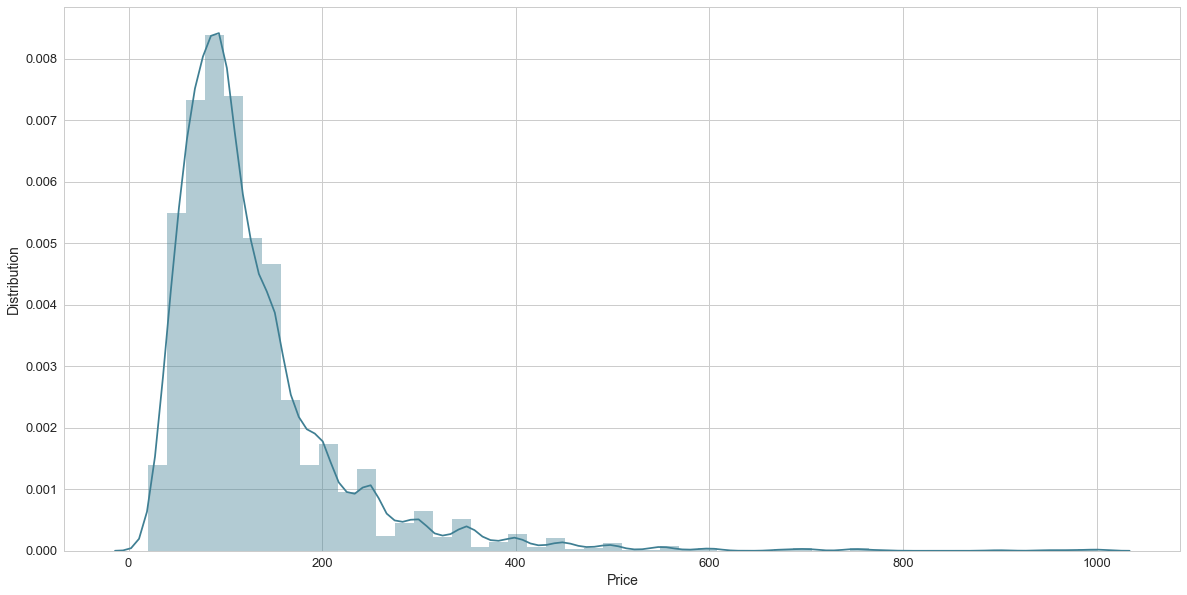

Skew is: 3.11312267004


In [5]:
ax = get_sub_plot()
sns.distplot(df.price, ax = ax)
plt.xlabel('Price')
plt.ylabel('Distribution')
plt.show()

print ("Skew is:", df.price.skew())

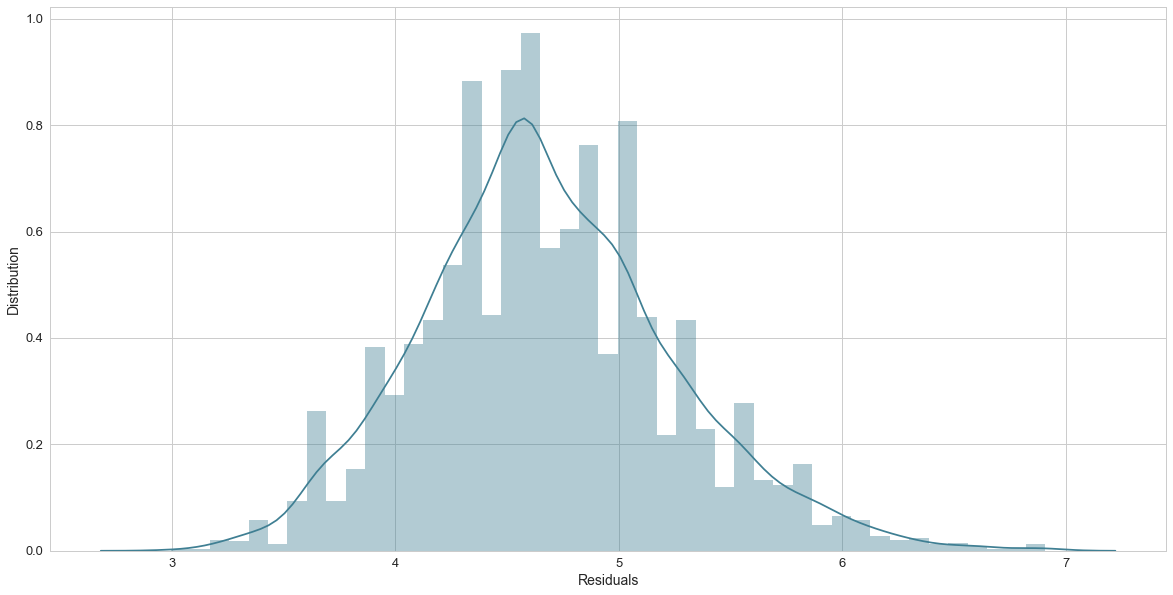

Skew is: 0.372413830121


In [6]:
df['price_log'] = np.log(df.price)

ax = get_sub_plot()
sns.distplot(df['price_log'], ax = ax)
plt.xlabel('Residuals')
plt.ylabel('Distribution')
plt.show()

print ("Skew is:", df.price_log.skew())

In [7]:
df_property_type_onehot = pd.get_dummies(df['property_type'], prefix = 'property_type')
df_property_type_onehot.head()

,property_type_0,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,property_type_6,property_type_7,property_type_8,property_type_9,property_type_10,property_type_11,property_type_12,property_type_13,property_type_14,property_type_15,property_type_16
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [8]:
df_neighbourhood_cleansed_onehot = pd.get_dummies(df['neighbourhood_cleansed'], prefix = 'neighbourhood_cleansed')
df_neighbourhood_cleansed_onehot.head()

,neighbourhood_cleansed_0,neighbourhood_cleansed_1,neighbourhood_cleansed_2,neighbourhood_cleansed_3,neighbourhood_cleansed_4,neighbourhood_cleansed_5,neighbourhood_cleansed_6,neighbourhood_cleansed_7,neighbourhood_cleansed_8,neighbourhood_cleansed_9,...,neighbourhood_cleansed_77,neighbourhood_cleansed_78,neighbourhood_cleansed_79,neighbourhood_cleansed_80,neighbourhood_cleansed_81,neighbourhood_cleansed_82,neighbourhood_cleansed_83,neighbourhood_cleansed_84,neighbourhood_cleansed_85,neighbourhood_cleansed_86
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [9]:
# df_X = pd.concat([df[['accommodates', 'bathrooms', 'bedrooms']], df_property_type_onehot, df_neighbourhood_cleansed_onehot], axis = 1)
df_X = pd.concat([df[['accommodates', 'bathrooms', 'bedrooms']], df_property_type_onehot], axis = 1)
df_X.head()

,accommodates,bathrooms,bedrooms,property_type_0,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,property_type_6,property_type_7,property_type_8,property_type_9,property_type_10,property_type_11,property_type_12,property_type_13,property_type_14,property_type_15,property_type_16
0,4,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,11,4.5,5.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6,2.0,3.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [10]:
X = df_X.as_matrix()
y = df['price_log'].as_matrix()
print(X)
print(y)

[[  4.    1.    1.  ...,   0.    0.    0. ]
 [  4.    1.    1.  ...,   0.    0.    0. ]
 [ 11.    4.5   5.  ...,   0.    0.    0. ]
 ..., 
 [  2.    1.    1.  ...,   0.    0.    0. ]
 [  2.    1.    0.  ...,   0.    0.    0. ]
 [  3.    1.5   2.  ...,   0.    0.    0. ]]
[ 4.44265126  5.01063529  6.88243747 ...,  4.53259949  4.59511985
  4.46590812]


### Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.33)

### Model 1: Linear Regression

In [12]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
print(lm.coef_)

[ 0.14520083  0.08559149  0.12695366  0.15332319  0.09563344  0.55100114
  0.1834833   0.08357111  0.36758057 -0.13324829  0.29610939 -1.53140252
 -0.0813069   0.20270328  0.06068227 -0.48836939 -0.04969647  0.09962683
  0.20354782 -0.01323876]


In [13]:
print ("Training Set R^2 is:", lm.score(X_train, y_train))
print ("Test Set R^2 is:", lm.score(X_test, y_test))

Training Set R^2 is: 0.502297560407
Test Set R^2 is: 0.495862396609


In [14]:
y_pred = lm.predict(X_test)

from sklearn.metrics import mean_squared_error
print ('RMSE is: \n', mean_squared_error(y_test, y_pred))

RMSE is: 
 0.165486399166


Text(0.5,1,'Relationship between Price and Predicted Price')

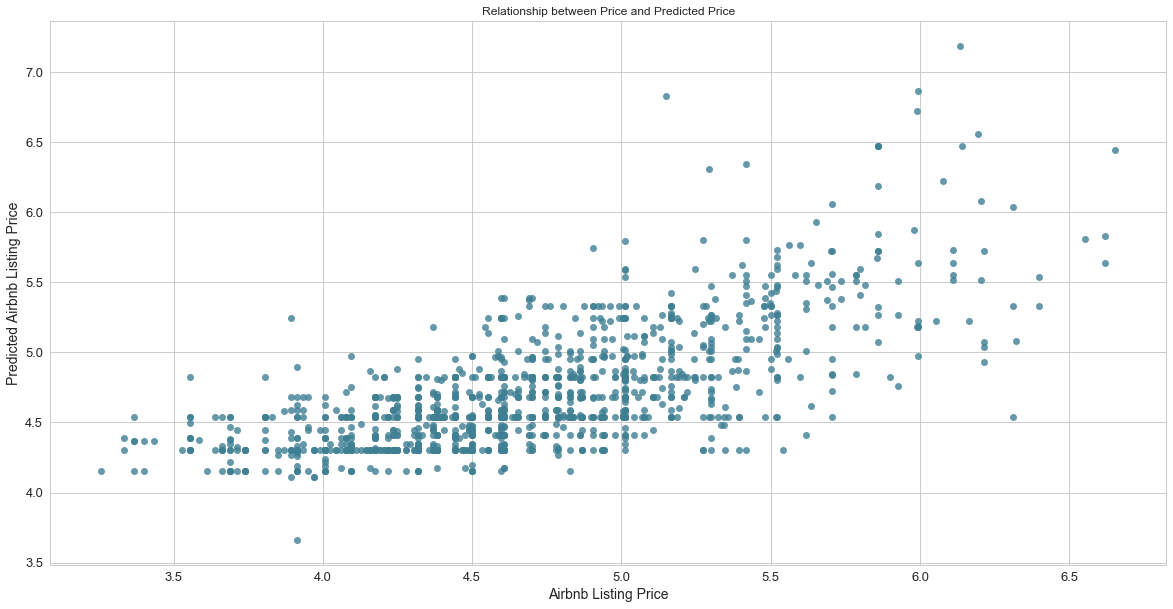

In [15]:
ax = get_sub_plot()
sns.regplot(y_test, y_pred, fit_reg = False, ax = ax)
plt.xlabel("Airbnb Listing Price")
plt.ylabel("Predicted Airbnb Listing Price")
plt.title("Relationship between Price and Predicted Price")

Text(0.5,1,'Relationship between Price and Predicted Price')

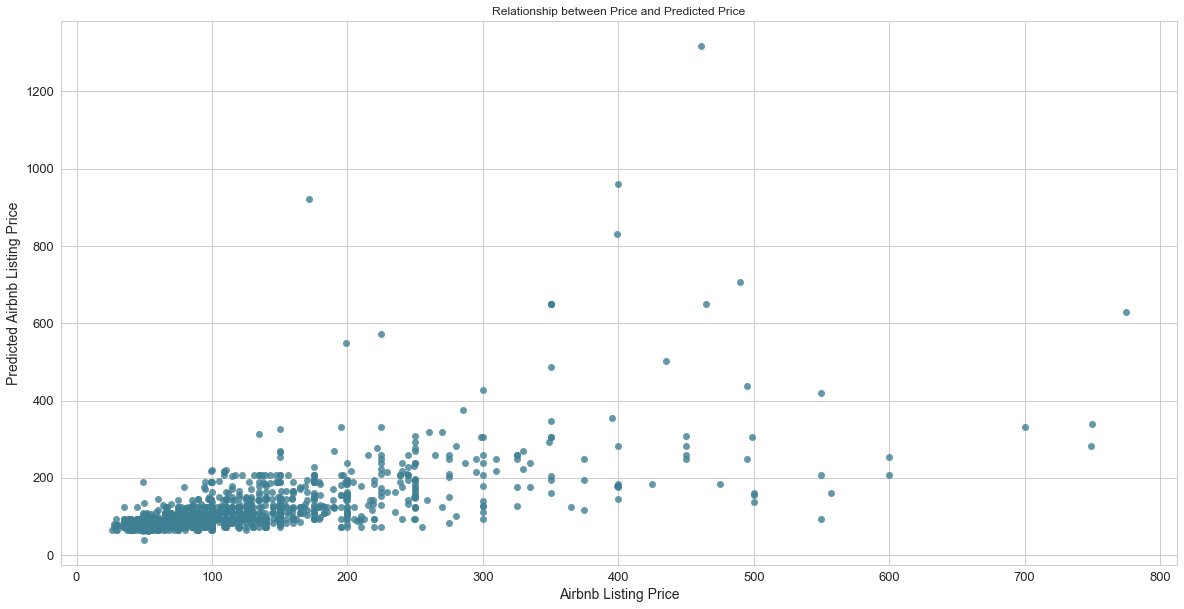

In [16]:
ax = get_sub_plot()
sns.regplot(np.exp(y_test), np.exp(y_pred), fit_reg = False, ax = ax)
plt.xlabel("Airbnb Listing Price")
plt.ylabel("Predicted Airbnb Listing Price")
plt.title("Relationship between Price and Predicted Price")

### Model 2: Ridge Regularization Model

### Model 3: Lasso Regularization Model

### Model 4: KNN